<a href="https://colab.research.google.com/github/Radperia/SIGNATE_student_2020/blob/master/SIGNATE_Tfidf_LogisticRegreession.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

次はここを参考にしていきたい  
https://copypaste-ds.hatenablog.com/entry/2019/02/01/174135#%E3%81%AF%E3%81%98%E3%82%81%E3%81%AB  
翻訳してaugmentationするの面白そう  
先にやるのはLightGBMでモデル作ってからのスタッキングだけど  
  
Optunaはcolabと相性が悪いのかもしれない(出力が表示されない)  
翻訳してデータ増やして、LightGBMとスタッキングでスコア稼ぎたい  

LightGBMのスコアがあまり良くないから、LR中心で仕上げる  
元々のデータをあまり綺麗にしてないから、綺麗にしてから再学習  


In [1]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00656759days (567.44sec)


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from scipy.sparse import hstack

from google.colab import files
import re
import string

from wordcloud import STOPWORDS
from collections import defaultdict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import chainer
!pip install chainercv
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain

     |████████████████████████████████| 266kB 4.4MB/s 
  Created wheel for chainercv: filename=chainercv-0.13.1-cp36-cp36m-linux_x86_64.whl size=537339 sha256=e7f2b4c1be455a79e5f8fa04a87a7bdb8a59d2b5d6574e4cafd8a4bd5d2aad65
  Stored in directory: /root/.cache/pip/wheels/ea/10/01/e221beaa4b3d8341aa819a39ab8d4677457c79c81f521f3a94
Successfully built chainercv


In [ ]:
import cv2
chainer.print_runtime_info()

Platform: Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 7.4.0
ChainerX: Not Available
NumPy: 1.18.5
CuPy:
  CuPy Version          : 7.4.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10010
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10010
  cuBLAS Version        : 10201
  cuFFT Version         : 10101
  cuRAND Version        : 10101
  cuSOLVER Version      : (10, 2, 0)
  cuSPARSE Version      : 10300
  NVRTC Version         : (10, 1)
  cuDNN Build Version   : 7605
  cuDNN Version         : 7605
  NCCL Build Version    : 2506
  NCCL Runtime Version  : 2506
iDeep: 2.0.0.post3


In [ ]:
!pip install optuna
import optuna

     |████████████████████████████████| 235kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 8.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 133kB 14.0MB/s 
     |████████████████████████████████| 112kB 14.8MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=72b3b453a3de4494fb625516acfa4c19cf7d81447003d797db39b2c9a8dd5dee
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-2.0.0-cp36-none-any.whl size=312964 sha256=68d50bf2bf1ec59ad4a4026d2afd0781684f38b587922059e73f9bcca526e553
  Stored in directory: /root/.cache/pip/wheels/b5/

In [4]:
class_names = ['DataScientist', 'MachineLearningEngineer', 'SoftwareEngineer', 'Consultant']

train = pd.read_csv('./drive/My Drive/SIGNATE/train.csv').fillna(' ')
augmented_train = pd.read_csv('./drive/My Drive/SIGNATE/augmented_data.csv').fillna(' ')
test = pd.read_csv('./drive/My Drive/SIGNATE/test.csv').fillna(' ')

In [ ]:
train

,id,description,jobflag
0,0,"Executes and writes portions of testing plans,...",2
1,1,Maintain Network Performance by assisting with...,3
2,2,Supports the regional compliance manager with ...,4
3,3,Keep up to date with local and national busine...,1
4,4,Assist with Service Organization Control (SOC)...,4
...,...,...,...
2926,2926,Preparation of reports for operational and man...,3
2927,2927,Line and/or indirect management of up to 20 st...,3
2928,2928,Partner with external agencies as needed,1
2929,2929,"Design, Implement and test software for embedd...",3


Text(0.5, 1.0, 'train_data')

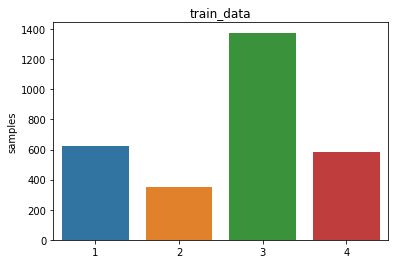

In [36]:
jobflag_vals = train.jobflag.value_counts()
sns.barplot(jobflag_vals.index, jobflag_vals)
plt.gca().set_ylabel('samples')
plt.gca().set_title('train_data')

Removing urls

In [6]:
train_text = train['description']
test_text = test['description']

augmented_train_text = augmented_train['description']

all_text = pd.concat([train_text, test_text])

augmented_all_text = pd.concat([augmented_train_text, test_text])

In [ ]:
train_text

0       Executes and writes portions of testing plans,...
1       Maintain Network Performance by assisting with...
2       Supports the regional compliance manager with ...
3       Keep up to date with local and national busine...
4       Assist with Service Organization Control (SOC)...
                              ...                        
2926    Preparation of reports for operational and man...
2927    Line and/or indirect management of up to 20 st...
2928             Partner with external agencies as needed
2929    Design, Implement and test software for embedd...
2930    Undertake to preprocess of structured and unst...
Name: description, Length: 2931, dtype: object

In [ ]:
test_text

0                      Work with the implementation teams
1       Set technology direction, strategy, policies, ...
2       Experience with Orchestration and Automation p...
3       Apply your expertise in quantitative analysis,...
4       Provide regular maintenance for knowledge rete...
                              ...                        
1738    Conduct data analysis to make business recomme...
1739    Obtain shipping bills of lading and necessary ...
1740    Connect and collaborate with subject matter ex...
1741    Ensures continuity of business execution i.e. ...
1742    The team will be involved in providing virtual...
Name: description, Length: 1743, dtype: object

In [7]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 2.7MB/s 


In [8]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [9]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

correct_spellingsめっちゃ時間かかる、train test合わせて27分くらい

In [ ]:
train_text = train_text.apply(lambda x: remove_html(x))
train_text = train_text.apply(lambda x: remove_URL(x))
train_text = train_text.apply(lambda x: remove_punct(x))
train_text = train_text.apply(lambda x: correct_spellings(x))

test_text = test_text.apply(lambda x: remove_html(x))
test_text = test_text.apply(lambda x: remove_URL(x))
test_text = test_text.apply(lambda x: remove_punct(x))
test_text = test_text.apply(lambda x: correct_spellings(x))

In [12]:
augmented_train_text = augmented_train_text.apply(lambda x: remove_html(x))
augmented_train_text = augmented_train_text.apply(lambda x: remove_URL(x))
augmented_train_text = augmented_train_text.apply(lambda x: remove_punct(x))

test_text = test_text.apply(lambda x: remove_html(x))
test_text = test_text.apply(lambda x: remove_URL(x))
test_text = test_text.apply(lambda x: remove_punct(x))
test_text = test_text.apply(lambda x: correct_spellings(x))

In [ ]:
train_text

0       Executes and writes portions of testing plans ...
1       Maintain Network Performance by assisting with...
2       Supports the regional compliance manager with ...
3       Keep up to date with local and national busine...
4       Assist with Service Organization Control SOC e...
                              ...                        
2926    Preparation of reports for operational and man...
2927    Line and/or indirect management of up to 20 st...
2928             Partner with external agencies as needed
2929    Design Implement and test software for embedde...
2930    Undertake to reprocess of structured and unstr...
Name: description, Length: 2931, dtype: object

In [11]:
augmented_train_text

0         Executes and writes portions of testing plans ...
1         Maintain Network Performance by assisting with...
2         Supports the regional compliance manager with ...
3         Keep up to date with local and national busine...
4         Assist with Service Organization Control SOC e...
                                ...                        
122748    Undertake to preprocess of integrated and unin...
122749    Undertake to preprocess of structured and amor...
122750    Undertake to preprocess of structured and unst...
122751    Undertake to preprocess of structured and unst...
122752    Undertake to preprocess of structured and unst...
Name: description, Length: 122753, dtype: object

In [ ]:
test_text

0                      Work with the implementation teams
1       Set technology direction strategy policies and...
2       Experience with Orchestration and Automation p...
3       Apply your expertise in quantitative analysis ...
4       Provide regular maintenance for knowledge rete...
                              ...                        
1738    Conduct data analysis to make business recomme...
1739    Obtain shipping bills of lading and necessary ...
1740    Connect and collaborate with subject matter ex...
1741    Ensures continuity of business execution ie op...
1742    The team will be involved in providing visuali...
Name: description, Length: 1743, dtype: object

In [ ]:
all_text = pd.concat([train_text, test_text])

In [ ]:
augmented_all_text = pd.concat([augmented_train_text, test_text])

In [ ]:
train_test = pd.DataFrame()
train_test['train_text'] = train_text
train_test['test_text'] = test_text

train_test.to_csv("train_test.csv")
from google.colab import files
files.download('train_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in range(len(train_text)):
    if(train_text[i] != train['description'][i]):
        print(train_text[i])
        print(train['description'][i])
        print('---------------------------------------------------------')

ストリーミング出力は最後の 5000 行に切り捨てられました。
---------------------------------------------------------
Perform data analysis to identify algorithms technical limitations or defects document findings and suggest solutions
Perform data analysis to identify algorithms technical limitations or defects, document findings and suggest solutions
---------------------------------------------------------
Provide technical assistance and data analysis support for other MV engineers
Provide technical assistance and data analysis support for other M&V engineers.
---------------------------------------------------------
Notifies possible resident of application approval or disapproval Assists qualified residents with completing lease agreement and collects initial rent and deposit payments Assists new residents with the move process
Notifies possible resident of application approval or disapproval. Assists qualified residents with completing lease agreement and collects initial rent and deposit payments. Assists

Augmentation

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import wordnet
wordnet.synsets("subscribe")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[Synset('subscribe.v.01'),
 Synset('sign.v.01'),
 Synset('subscribe.v.03'),
 Synset('pledge.v.02'),
 Synset('subscribe.v.05')]

In [ ]:
percent = 50

In [ ]:
from collections import OrderedDict
from nltk.tokenize import word_tokenize
def find_synonyms(word):
  synonyms = []
  for synset in wordnet.synsets(word):
    for syn in synset.lemma_names():
      synonyms.append(syn)

  # using this to drop duplicates while maintaining word order (closest synonyms comes first)
  synonyms_without_duplicates = list(OrderedDict.fromkeys(synonyms))
  return synonyms_without_duplicates

find_synonyms("subscribe")

def create_set_of_new_sentences(sentence, max_syn_per_word = 6):
  new_sentences = []
  for word in word_tokenize(sentence):
    if len(word)<=3 : continue 
    for synonym in find_synonyms(word)[0:max_syn_per_word]:
      synonym = synonym.replace('_', ' ') #restore space character
      new_sentence = sentence.replace(word,synonym)
      new_sentences.append(new_sentence)
  return new_sentences

def data_augment_synonym_replacement(data, column='subject'):
  generated_data = pd.DataFrame([], columns=data.columns)
  for index in data.index:
    text_to_augment = data[column][index]
    for generated_sentence in create_set_of_new_sentences(text_to_augment):
      new_entry =  data.loc[[index]]
      new_entry[column] = generated_sentence
      generated_data=generated_data.append(new_entry)

  generated_data_df = generated_data.drop_duplicates()
  augmented_data= pd.concat([data.loc[:],generated_data_df], ignore_index=True)
  return augmented_data

In [ ]:
augmented_data = data_augment_synonym_replacement(train, column='description')

In [ ]:
augmented_data.shape

(122753, 7)

In [ ]:
augmented_data.to_csv('augmented_data.csv', index=False)

from google.colab import files
files.download('augmented_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
train['DataScientist'] = 0
train['MachineLearningEngineer'] = 0
train['SoftwareEngineer'] = 0
train['Consultant'] = 0

print(train['jobflag'][2])

4


In [ ]:
# カッコいい書き方が分からない

for i in range(train.shape[0]):

    if(train['jobflag'][i]==1):
        train['DataScientist'][i]=1

    elif(train['jobflag'][i]==2):
        train['MachineLearningEngineer'][i]=1

    elif(train['jobflag'][i]==3):
        train['SoftwareEngineer'][i]=1
        
    elif(train['jobflag'][i]==4):
        train['Consultant'][i]=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/pyth

In [ ]:
train

,id,description,jobflag,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant
0,0,"Executes and writes portions of testing plans,...",2,0,1,0,0
1,1,Maintain Network Performance by assisting with...,3,0,0,1,0
2,2,Supports the regional compliance manager with ...,4,0,0,0,1
3,3,Keep up to date with local and national busine...,1,1,0,0,0
4,4,Assist with Service Organization Control (SOC)...,4,0,0,0,1
...,...,...,...,...,...,...,...
2926,2926,Preparation of reports for operational and man...,3,0,0,1,0
2927,2927,Line and/or indirect management of up to 20 st...,3,0,0,1,0
2928,2928,Partner with external agencies as needed,1,1,0,0,0
2929,2929,"Design, Implement and test software for embedd...",3,0,0,1,0


In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [ ]:
DS = train['jobflag'] == 1
MLE = train['jobflag'] == 2 
SE = train['jobflag'] == 3
C = train['jobflag'] == 4

In [ ]:
DS_bigrams = defaultdict(int)
MLE_bigrams = defaultdict(int)
SE_bigrams = defaultdict(int)
C_bigrams = defaultdict(int)

for desc in train[DS]['description']:
    for word in generate_ngrams(desc, n_gram=2):
        DS_bigrams[word] += 1

for desc in train[MLE]['description']:
    for word in generate_ngrams(desc, n_gram=2):
        MLE_bigrams[word] += 1

for desc in train[SE]['description']:
    for word in generate_ngrams(desc, n_gram=2):
        SE_bigrams[word] += 1

for desc in train[C]['description']:
    for word in generate_ngrams(desc, n_gram=2):
        C_bigrams[word] += 1

df_DS_bigrams = pd.DataFrame(sorted(DS_bigrams.items(), key=lambda x: x[1])[::-1])
df_MLE_bigrams = pd.DataFrame(sorted(MLE_bigrams.items(), key=lambda x: x[1])[::-1])
df_SE_bigrams = pd.DataFrame(sorted(SE_bigrams.items(), key=lambda x: x[1])[::-1])
df_C_bigrams = pd.DataFrame(sorted(C_bigrams.items(), key=lambda x: x[1])[::-1])

In [ ]:
df_MLE_bigrams

,0,1
0,machine learning,52
1,data science,10
2,data scientists,9
3,learning models,8
4,work closely,8
...,...,...
2726,"plans, protocols,",1
2727,"testing plans,",1
2728,portions testing,1
2729,writes portions,1


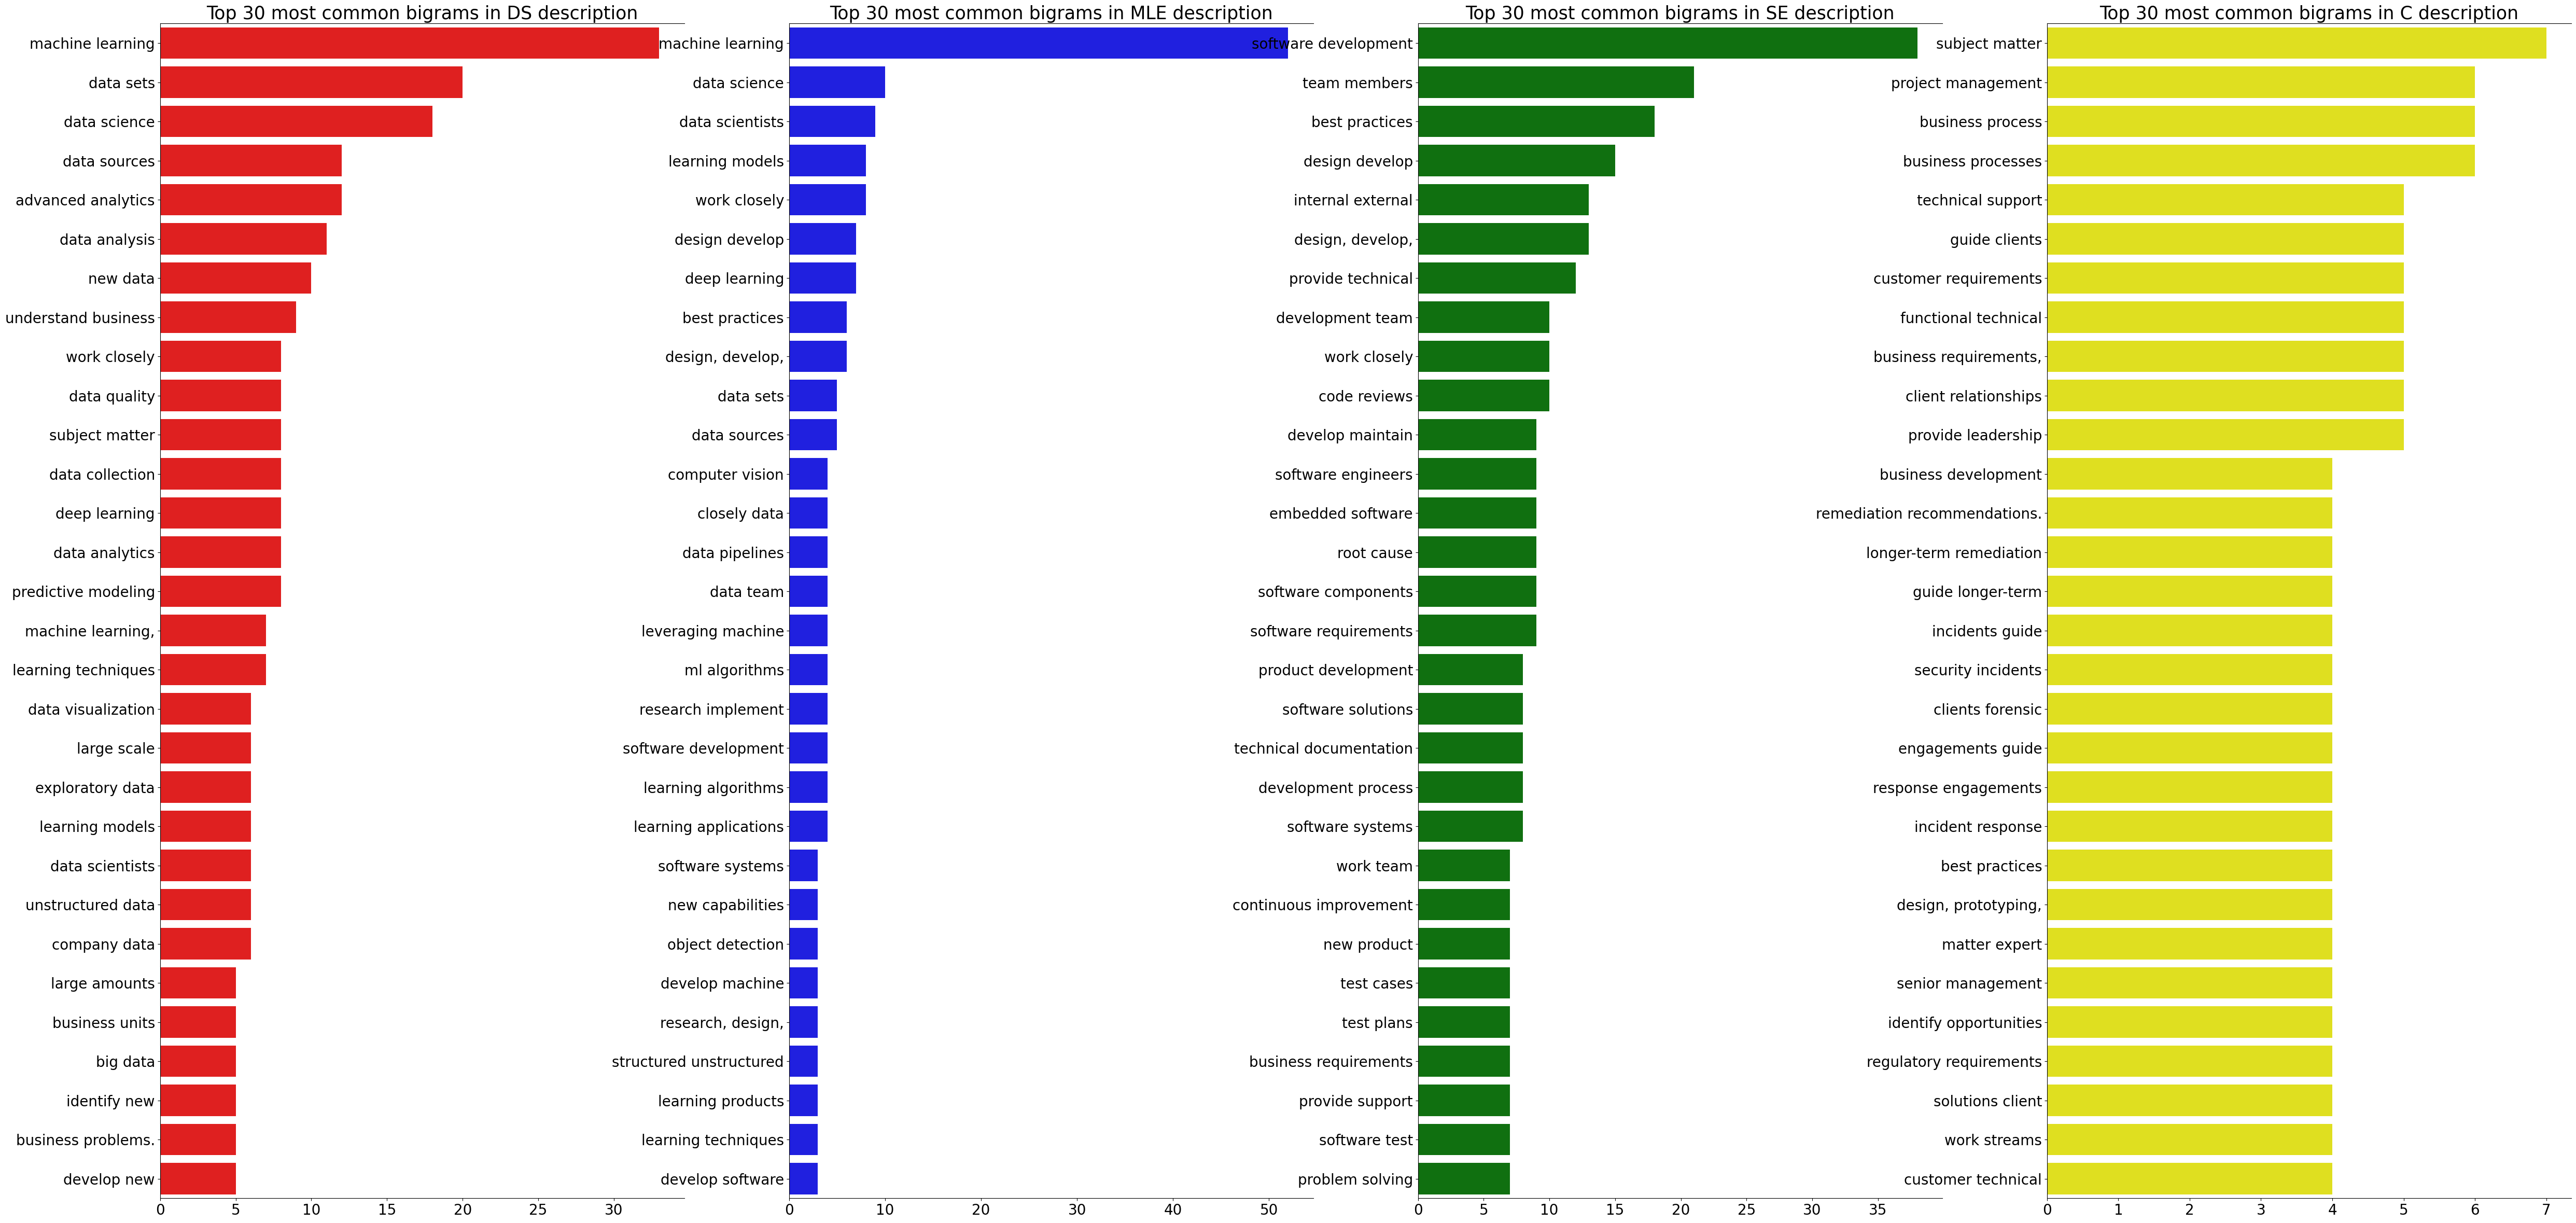

In [ ]:
N = 30

fig, axes = plt.subplots(ncols=4, figsize=(60, 30), dpi=100)

sns.barplot(y=df_DS_bigrams[0].values[:N], x=df_DS_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_MLE_bigrams[0].values[:N], x=df_MLE_bigrams[1].values[:N], ax=axes[1], color='blue')
sns.barplot(y=df_SE_bigrams[0].values[:N], x=df_SE_bigrams[1].values[:N], ax=axes[2], color='green')
sns.barplot(y=df_C_bigrams[0].values[:N], x=df_C_bigrams[1].values[:N], ax=axes[3], color='yellow')

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)

axes[0].set_title(f'Top {N} most common bigrams in DS description', fontsize=25)
axes[1].set_title(f'Top {N} most common bigrams in MLE description', fontsize=25)
axes[2].set_title(f'Top {N} most common bigrams in SE description', fontsize=25)
axes[3].set_title(f'Top {N} most common bigrams in C description', fontsize=25)

plt.show()
fig.savefig("bigram.jpg")

In [ ]:
DS_trigrams = defaultdict(int)
MLE_trigrams = defaultdict(int)
SE_trigrams = defaultdict(int)
C_trigrams = defaultdict(int)

for desc in train[DS]['description']:
    for word in generate_ngrams(desc, n_gram=3):
        DS_trigrams[word] += 1

for desc in train[MLE]['description']:
    for word in generate_ngrams(desc, n_gram=3):
        MLE_trigrams[word] += 1

for desc in train[SE]['description']:
    for word in generate_ngrams(desc, n_gram=3):
        SE_trigrams[word] += 1

for desc in train[C]['description']:
    for word in generate_ngrams(desc, n_gram=3):
        C_trigrams[word] += 1

df_DS_trigrams = pd.DataFrame(sorted(DS_trigrams.items(), key=lambda x: x[1])[::-1])
df_MLE_trigrams = pd.DataFrame(sorted(MLE_trigrams.items(), key=lambda x: x[1])[::-1])
df_SE_trigrams = pd.DataFrame(sorted(SE_trigrams.items(), key=lambda x: x[1])[::-1])
df_C_trigrams = pd.DataFrame(sorted(C_trigrams.items(), key=lambda x: x[1])[::-1])

In [ ]:
df_MLE_trigrams

,0,1
0,machine learning models,8
1,work closely data,4
2,machine learning applications,4
3,develop machine learning,3
4,machine learning algorithms,3
...,...,...
2636,"plans, protocols, documentation",1
2637,"testing plans, protocols,",1
2638,"portions testing plans,",1
2639,writes portions testing,1


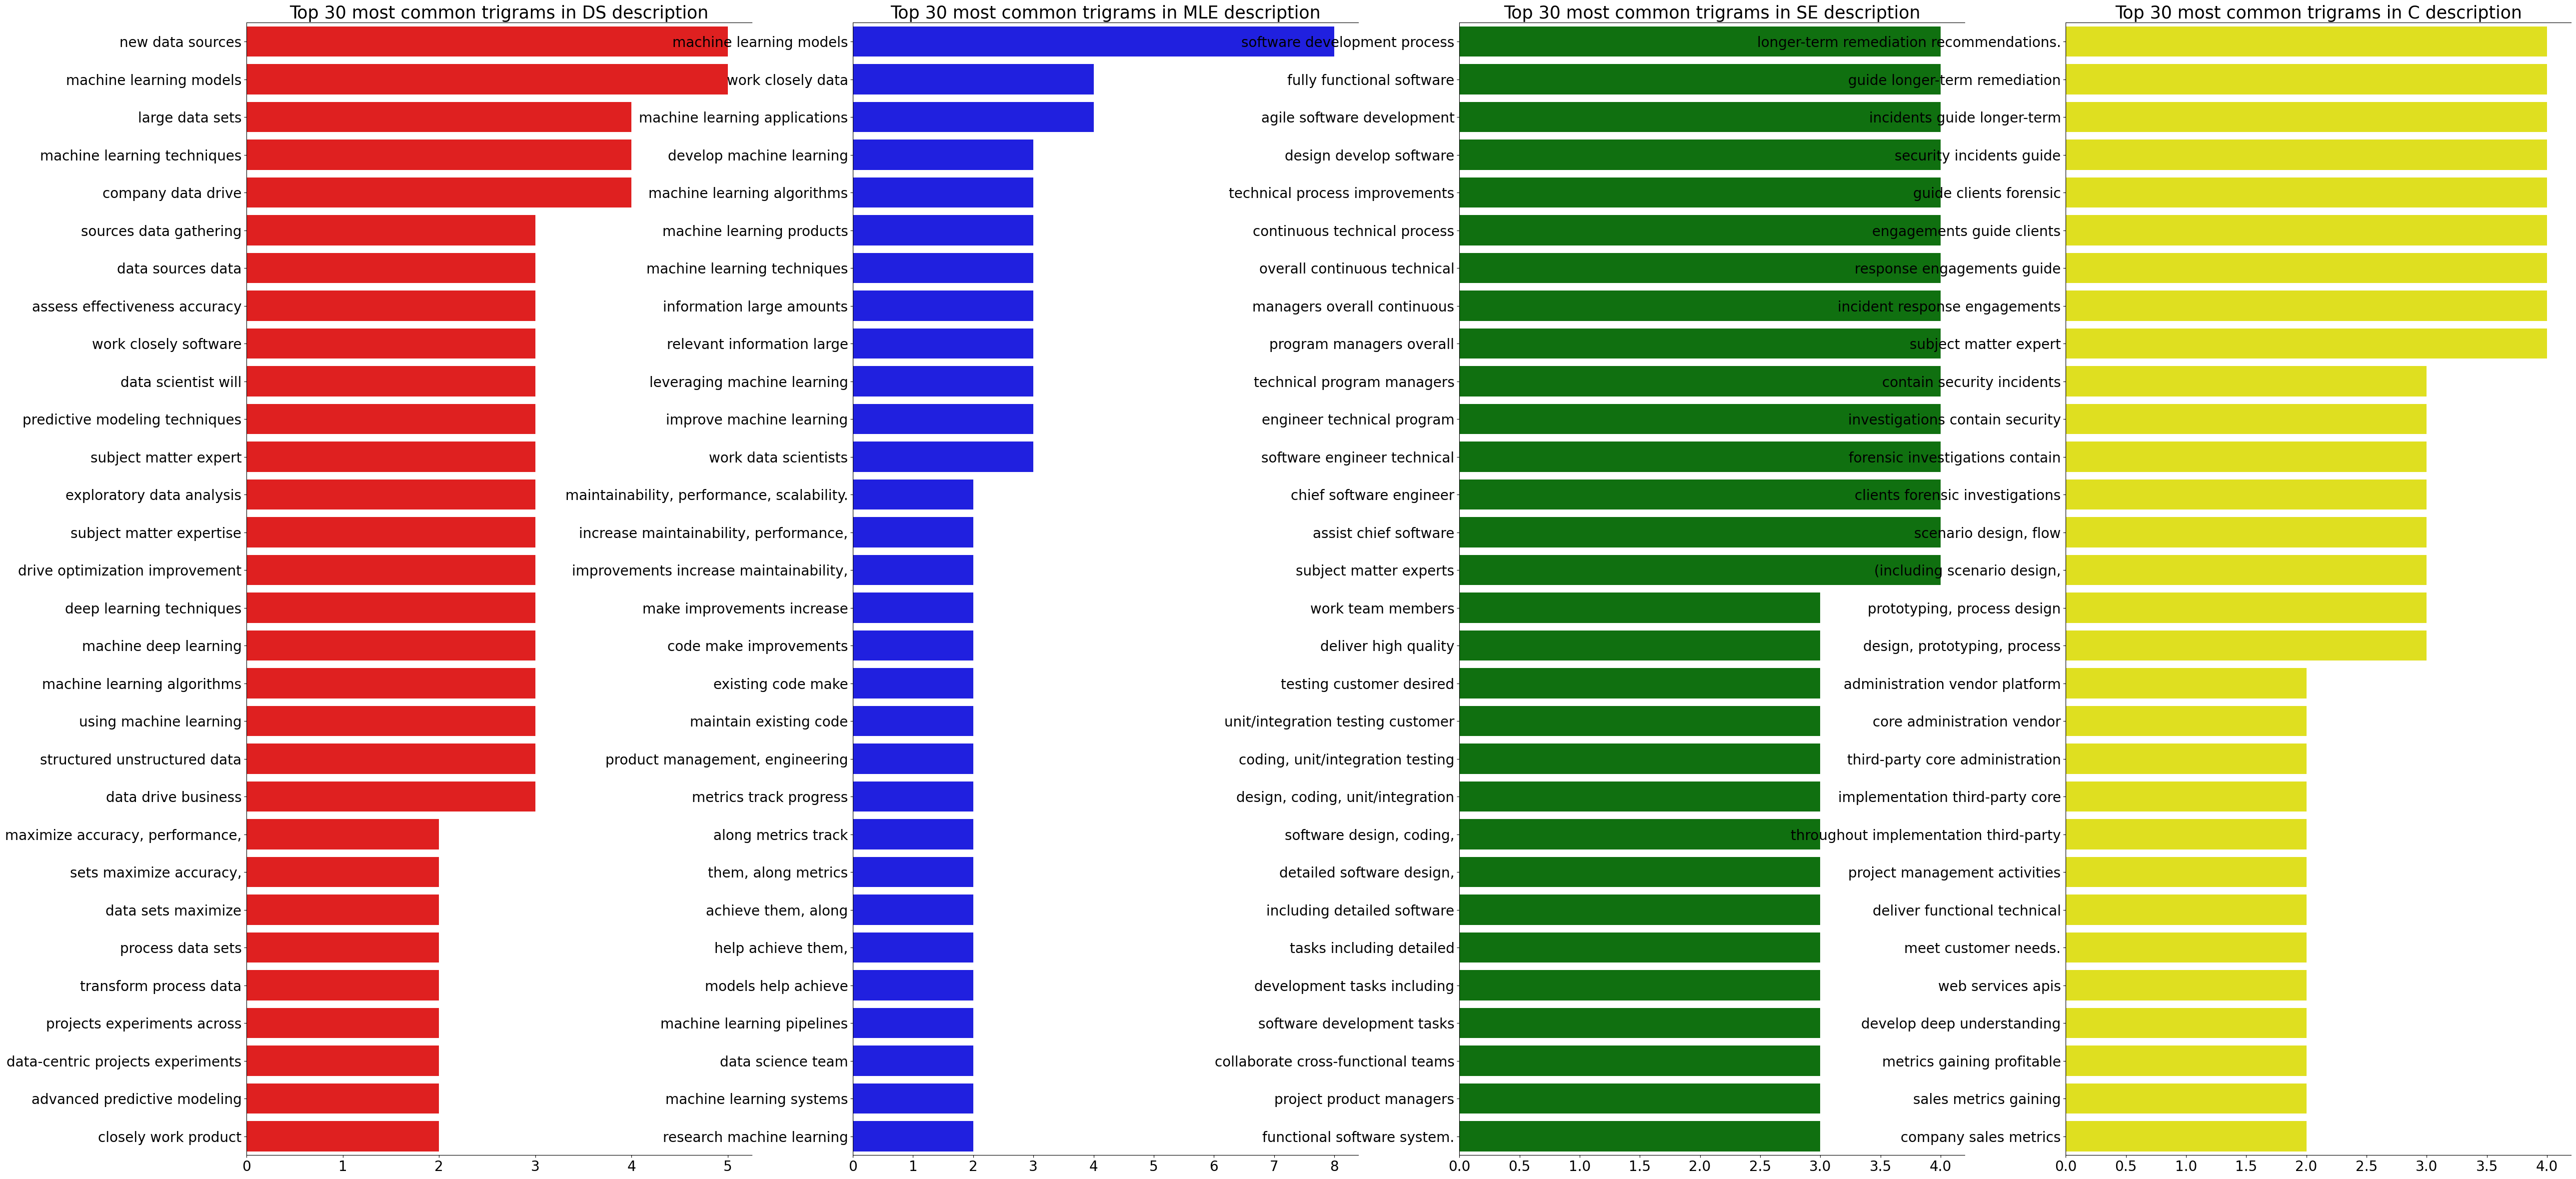

In [ ]:
N = 30

fig, axes = plt.subplots(ncols=4, figsize=(60, 30), dpi=100)

sns.barplot(y=df_DS_trigrams[0].values[:N], x=df_DS_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_MLE_trigrams[0].values[:N], x=df_MLE_trigrams[1].values[:N], ax=axes[1], color='blue')
sns.barplot(y=df_SE_trigrams[0].values[:N], x=df_SE_trigrams[1].values[:N], ax=axes[2], color='green')
sns.barplot(y=df_C_trigrams[0].values[:N], x=df_C_trigrams[1].values[:N], ax=axes[3], color='yellow')

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)

axes[0].set_title(f'Top {N} most common trigrams in DS description', fontsize=25)
axes[1].set_title(f'Top {N} most common trigrams in MLE description', fontsize=25)
axes[2].set_title(f'Top {N} most common trigrams in SE description', fontsize=25)
axes[3].set_title(f'Top {N} most common trigrams in C description', fontsize=25)

plt.show()
fig.savefig("trigram.jpg")

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=20000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [14]:
aug_word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=20000)
aug_word_vectorizer.fit(augmented_all_text)
aug_train_word_features = aug_word_vectorizer.transform(augmented_train_text)
aug_test_word_features = aug_word_vectorizer.transform(test_text)

In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 4),
    max_features=40000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [16]:
aug_char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 4),
    max_features=40000)
aug_char_vectorizer.fit(augmented_all_text)
aug_train_char_features = aug_char_vectorizer.transform(augmented_train_text)
aug_test_char_features = aug_char_vectorizer.transform(test_text)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [ ]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [17]:
aug_train_features = hstack([aug_train_char_features, aug_train_word_features])
aug_test_features = hstack([aug_test_char_features, aug_test_word_features])

In [ ]:
train_features.shape

(2931, 23836)

In [ ]:
test_features.shape

(2931, 23836)

In [20]:
aug_train_features

<122753x49927 sparse matrix of type '<class 'numpy.float64'>'
	with 39921817 stored elements in COOrdinate format>

In [19]:
aug_test_features

<1743x49927 sparse matrix of type '<class 'numpy.float64'>'
	with 496244 stored elements in COOrdinate format>

LogisticRegression

In [ ]:
scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})

for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C = 0.01, solver = 'sag', class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=10, scoring = 'f1_macro'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {}',format(np.mean(scores)))

CV score for class DataScientist is 0.7648344850372429
CV score for class MachineLearningEngineer is 0.673660873410592
CV score for class SoftwareEngineer is 0.752789830357412
CV score for class Consultant is 0.6900998879142406
Total CV score is {} 0.7203462691798719


In [ ]:
submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant
0,2931,0.479265,0.490079,0.494555,0.504652
1,2932,0.464602,0.481418,0.514028,0.494849
2,2933,0.478721,0.491641,0.504065,0.489609
3,2934,0.556721,0.491525,0.449550,0.489888
4,2935,0.466254,0.460344,0.505637,0.520394
...,...,...,...,...,...
1738,4669,0.552121,0.472250,0.455720,0.497338
1739,4670,0.469022,0.475281,0.505159,0.508220
1740,4671,0.496163,0.486404,0.490870,0.495161
1741,4672,0.486296,0.465862,0.493604,0.513879


augmented logistic regression

In [22]:
aug_scores = []
aug_submission = pd.DataFrame.from_dict({'id': test['id']})

for class_name in class_names:
    train_target = augmented_train[class_name]
    classifier = LogisticRegression(C = 0.01, solver = 'sag', class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, aug_train_features, train_target, cv=10, scoring = 'f1_macro'))
    aug_scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(aug_train_features, train_target)
    aug_submission[class_name] = classifier.predict_proba(aug_test_features)[:, 1]

print('Total CV score is {}',format(np.mean(aug_scores)))

CV score for class DataScientist is 0.7941123414240121
CV score for class MachineLearningEngineer is 0.6988579366278517
CV score for class SoftwareEngineer is 0.7830388493178356
CV score for class Consultant is 0.7438852440202018


NameError: ignored

LightGBM

In [ ]:
!git clone https://github.com/microsoft/LightGBM
!cd LightGBM && mkdir build && cd build && cmake .. && make -j"$(nproc)"
!cd LightGBM/python-package && python setup.py install --precompile

Cloning into 'LightGBM'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 19007 (delta 9), reused 25 (delta 3), pack-reused 18962
Receiving objects: 100% (19007/19007), 14.90 MiB | 22.40 MiB/s, done.
Resolving deltas: 100% (13862/13862), done.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found O

In [ ]:
lgb_submission = pd.DataFrame.from_dict({'id': test['id']})

評価関数設定

In [ ]:
import lightgbm as lgb

calc_f1 = lambda y, p: metrics.f1_score(y, p.argmax(axis=1), average='macro')

def macro_f1(pred: np.array, data: lgb.Dataset):
    y = data.get_label()
    pred = pred.reshape(-1, len(y)).T  # -> (N, num_class)

    f1 = calc_f1(y, pred)
    return 'macro_f1', f1, True  # True means "higher is better"

Optuna 探索処理

In [ ]:
best_params = {}
tuning_history = []

for class_name in class_names:
    print(class_name)
    train_target = train[class_name]
    model = LogisticRegression(solver='sag')
    sfm = SelectFromModel(model, threshold=0.2)
    train_sparse_matrix = sfm.fit_transform(train_features, train_target)

    train_sparse_matrix, valid_sparse_matrix, y_train, y_valid = train_test_split(train_sparse_matrix, train_target, test_size=0.1, random_state=42)
    test_sparse_matrix = sfm.transform(test_features)

    d_train = lgb.Dataset(train_sparse_matrix, label=y_train)
    d_valid = lgb.Dataset(valid_sparse_matrix, label=y_valid)
    watchlist = [d_train, d_valid]

    params = {
        'objective': 'binary',
        'metric': 'auc'
    }

    model = lgb.train(params, d_train, valid_sets=watchlist,
                      num_boost_round = 100, feval = macro_f1)
    
    print('Best Params:', best_params)
    print('Tuning history:', tuning_history)

DataScientist


LightGBMError: ignored

In [ ]:
model.best_score

defaultdict(dict,
            {'training': {'auc': 1.0, 'macro_f1': 0.44612476370510395},
             'valid_1': {'auc': 0.8330676020408163,
              'macro_f1': 0.4324324324324324}})

In [ ]:
model.params

{'metric': 'auc', 'objective': 'binary'}

lightGBM学習  
ただ良くない、使わない

In [ ]:
for class_name in class_names:
    print(class_name)
    train_target = train[class_name]
    tuned_model = LogisticRegression(solver='sag')
    sfm = SelectFromModel(tuned_model, threshold=0.2)
    train_sparse_matrix = sfm.fit_transform(train_features, train_target)
    print(train_features.shape)
    train_sparse_matrix, valid_sparse_matrix, y_train, y_valid = train_test_split(train_sparse_matrix, train_target, test_size=0.1, random_state=42)

    test_sparse_matrix = sfm.transform(test_features)
    print(train_sparse_matrix.shape)
    d_train = lgb.Dataset(train_sparse_matrix, label=y_train)
    d_valid = lgb.Dataset(valid_sparse_matrix, label=y_valid)
    watchlist = [d_train, d_valid]

    params = {
        'learning_rate': 0.01,
        'bagging_fraction': 0.4398801119823031,
        'bagging_freq': 4,
        'feature_fraction': 0.5,
        'lambda_l1': 0,
        'lambda_l2': 0,
        'metric': 'auc',
        'min_child_samples': 20,
        'num_leaves': 216,
        'objective': 'binary'
    }

    tuned_model = lgb.train(params, train_set = d_train, valid_sets=watchlist)
    lgb_submission[class_name] = tuned_model.predict(test_sparse_matrix)

lgb_submission.to_csv('lgb_submisson.csv', index=False)

DataScientist
(2931, 155342)
(2637, 1630)
[LightGBM] [Info] Number of positive: 573, number of negative: 2064
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44247
[LightGBM] [Info] Number of data points in the train set: 2637, number of used features: 813
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217292 -> initscore=-1.281515
[LightGBM] [Info] Start training from score -1.281515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's auc: 0.819286	valid_1's auc: 0.825869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's auc: 0.842745	valid_1's auc: 0.827322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's auc: 0.847044	valid_1's auc: 0.839345
[LightGBM] [War

In [ ]:
lgb_submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant
0,2931,0.177287,0.077765,0.520269,0.176094
1,2932,0.096144,0.063537,0.611708,0.123405
2,2933,0.164853,0.111599,0.510260,0.138111
3,2934,0.585571,0.077224,0.214599,0.151882
4,2935,0.084948,0.118920,0.462399,0.332387
...,...,...,...,...,...
1738,4669,0.507506,0.074590,0.215952,0.129235
1739,4670,0.090990,0.085981,0.475775,0.251411
1740,4671,0.195214,0.054858,0.498659,0.171270
1741,4672,0.153432,0.086704,0.405047,0.231074


In [ ]:
lgb_submission['flag'] = 0

for i in range(lgb_submission.shape[0]):
    lgb_submission['flag'][i] = np.stack([lgb_submission['DataScientist'][i], lgb_submission['MachineLearningEngineer'][i], 
                                          lgb_submission['SoftwareEngineer'][i], lgb_submission['Consultant'][i]]).argmax() + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
lgb_submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant,flag
0,2931,0.177287,0.077765,0.520269,0.176094,3
1,2932,0.096144,0.063537,0.611708,0.123405,3
2,2933,0.164853,0.111599,0.510260,0.138111,3
3,2934,0.585571,0.077224,0.214599,0.151882,1
4,2935,0.084948,0.118920,0.462399,0.332387,3
...,...,...,...,...,...,...
1738,4669,0.507506,0.074590,0.215952,0.129235,1
1739,4670,0.090990,0.085981,0.475775,0.251411,3
1740,4671,0.195214,0.054858,0.498659,0.171270,3
1741,4672,0.153432,0.086704,0.405047,0.231074,3


In [ ]:
lgb_submission.to_csv('lgb_submission.csv', index=False)

from google.colab import files
files.download('lgb_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

dog形式のLGB用のデータ作成、学習

In [ ]:
my_params={
    'objective': 'multiclass',
    'metric': 'custom',
    'num_class': 4,
    'num_iterations': 10000,
    'learning_rate': 0.0001,
    'max_depth': -1,
    'num_leaves': 50,
    'max_bin': 300,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'nthread': -1,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 42,
}

In [ ]:
train_df = pd.read_csv('./drive/My Drive/SIGNATE/train.csv').fillna(' ')
test_df  = pd.read_csv('./drive/My Drive/SIGNATE/test.csv').fillna(' ')
sample = pd.read_csv('./drive/My Drive/SIGNATE/submit_sample.csv', header=None)

train_text = train_df['description']
test_text = test_df['description']
all_text = pd.concat([train_text, test_text])

sentences = train_df['description'].tolist() + test_df['description'].tolist()
sentences[::500]  # 500個飛ばしに確認

['Executes and writes portions of testing plans, protocols, and documentation for assigned portion of application; identifies and debugs issues with code and suggests changes or improvements.',
 'Knowledge and experience of complex software design for distributed systems in embedded networking/telecommunications projects.',
 'Analyze client business processes of storing and managing data.',
 'Defining tasks, timeline and required resources to deliver on the mechanical design portion of a project brief, with strong accountability for successful completion of agreed upon deliverables.',
 'Familiar with sensors, transducers, physiologic modeling, and transfer functions',
 'Manage, maintain, refresh and upgrade environmental components (including patching, etc.)',
 'Conduct research on cutting-edge techniques and tools in machine learning/deep learning/artificial intelligence',
 'Assist in planning and development of visualizations and analytic aggregations to best portray discovered insig

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  # 出現頻度上位{num_words}だけを用いる
tokenizer.fit_on_texts(sentences)
print(list(tokenizer.word_index)[:10] ) # 学習された辞書（出現頻度順）

['and', 'to', 'the', 'of', 'with', 'data', 'in', 'for', 'a', 'business']


In [ ]:
# 学習・検証に分けて，ベクトルを生成。加えて，正解ラベルも作成
train_X, test_X = np.split(tokenizer.texts_to_matrix(sentences, mode='binary'),
                           [len(train_df)], axis=0)

train_y = train_df['jobflag'].values - 1  # maps {1, 2, 3 ,4} -> {0, 1, 2, 3}
train_X.shape, train_y.shape, test_X.shape

((2931, 1000), (2931,), (1743, 1000))

In [ ]:
weight = 1 / pd.DataFrame(train_y).reset_index().groupby(0).count().values
weight = weight[train_y].ravel()
weight /= weight.sum()

print(weight)

dtrain = lgb.Dataset(train_X, train_y, weight=weight)

[0.00071839 0.00018169 0.00042882 ... 0.00040064 0.00018169 0.00071839]


In [ ]:
cvbooster = lgb.cv(my_params, dtrain ,return_cvbooster=True, stratified=False, num_boost_round=9999, verbose_eval=100, early_stopping_rounds=500, feval=macro_f1)['cvbooster']

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	cv_agg's macro_f1: 0.162847 + 0.106109
[200]	cv_agg's macro_f1: 0.260748 + 0.0620976
[300]	cv_agg's macro_f1: 0.350204 + 0.0615545
[400]	cv_agg's macro_f1: 0.40924 + 0.055696
[500]	cv_agg's macro_f1: 0.432424 + 0.0580208
[600]	cv_agg's macro_f1: 0.452867 + 0.0529274
[700]	cv_agg's macro_f1: 0.467598 + 0.0411209
[800]	cv_agg's macro_f1: 0.477578 + 0.0338144
[900]	cv_agg's macro_f1: 0.481542 + 0.0295524
[1000]	cv_agg's macro_f1: 0.486224 + 0.0268828
[1100]	cv_agg's macro_f1: 0.486453 + 0.0222633
[1200]	cv_agg's macro_f1: 0.490857 + 0.0183746
[1300]	cv_agg's macro_f1: 0.492214 + 0.0187859
[1400]	cv_agg's macro_f1: 0.491911 + 0.0185558
[1500]	cv_agg's macro_f1: 0.494003 + 0.0167483
[1600]	cv_agg's macro_f1: 0.496412 + 0.0161769
[1700]	cv_agg's macro_f1: 0.49888 + 0.0170035
[1800]	cv_agg's macro_f1: 0.49916 + 0.0168568
[1900]	cv_agg's macro_f1: 0.502178 + 0.0173298
[2000]	cv_agg's macro_f1: 0.50125 + 0.0183528


In [ ]:
np.stack(cvbooster.predict(test_X)).mean(axis=0)

array([[0.23619978, 0.22668077, 0.25650635, 0.28061309],
       [0.21787015, 0.22950183, 0.32803654, 0.22459148],
       [0.23223059, 0.22607484, 0.27273641, 0.26895816],
       ...,
       [0.22832259, 0.24628815, 0.2683025 , 0.25708676],
       [0.23273634, 0.22580318, 0.24616256, 0.29529792],
       [0.21747396, 0.23032402, 0.32507503, 0.22712699]])

In [ ]:
pred = np.stack(cvbooster.predict(test_X)).mean(axis=0).argmax(axis=1) + 1
pd.DataFrame(pred, index=test_df.index).to_csv('./dog_cv.csv', header=None)
files.download('dog_cv.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ここからsklearn RLとLight GBMの結果のスタッキング

In [ ]:
LightGBM_stacking = np.stack(cvbooster.predict(test_X)).mean(axis=0)

(1743, 4)

In [ ]:
LightGBM_DS = LightGBM_stacking[:,0]
LightGBM_MLE = LightGBM_stacking[:,1]
LightGBM_SE = LightGBM_stacking[:,2]
LightGBM_C = LightGBM_stacking[:,3]

In [ ]:
submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant
0,2931,0.497994,0.498560,0.499368,0.500643
1,2932,0.496737,0.497775,0.501245,0.499546
2,2933,0.497896,0.498514,0.500381,0.499198
3,2934,0.505228,0.498907,0.495321,0.499112
4,2935,0.496968,0.496044,0.500399,0.501764
...,...,...,...,...,...
1738,4669,0.504537,0.497298,0.496102,0.499673
1739,4670,0.497322,0.497435,0.500460,0.500381
1740,4671,0.499483,0.498544,0.499083,0.499536
1741,4672,0.498584,0.496918,0.499387,0.501068


In [ ]:
submission_DS = submission.iloc[:,1]
submission_MLE = submission.iloc[:,2]
submission_SE = submission.iloc[:,3]
submission_C = submission.iloc[:,4]

In [ ]:
stacking_DS = LightGBM_DS + submission_DS
stacking_MLE = LightGBM_MLE + submission_MLE
stacking_SE = LightGBM_SE + submission_SE
stacking_C = LightGBM_C + submission_C

In [ ]:
print(stacking_DS)

0       0.734194
1       0.714607
2       0.730126
3       0.853878
4       0.716534
          ...   
1738    0.855002
1739    0.741885
1740    0.727806
1741    0.731321
1742    0.713906
Name: DataScientist, Length: 1743, dtype: float64


In [ ]:
print(stacking_MLE)

0       0.725241
1       0.727277
2       0.724589
3       0.727014
4       0.715647
          ...   
1738    0.712513
1739    0.724072
1740    0.744832
1741    0.722721
1742    0.727800
Name: MachineLearningEngineer, Length: 1743, dtype: float64


In [ ]:
stacking = pd.DataFrame().from_dict({'id': test['id']})
stacking['DataScientist'] = LightGBM_DS + submission_DS
stacking['MachineLearningEngineer'] = LightGBM_MLE + submission_MLE
stacking['SoftwareEngineer'] = LightGBM_SE + submission_SE
stacking['Consultant'] = LightGBM_C + submission_C

In [ ]:
stacking

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant
0,2931,0.288559,0.281057,0.305079,0.324619
1,2932,0.273643,0.283156,0.362678,0.279582
2,2933,0.285364,0.280563,0.318265,0.315006
3,2934,0.379966,0.282267,0.265351,0.272130
4,2935,0.275047,0.274891,0.315690,0.333407
...,...,...,...,...,...
1738,4669,0.381279,0.271632,0.267686,0.278925
1739,4670,0.295114,0.280796,0.307069,0.316140
1740,4671,0.282555,0.296739,0.314459,0.305577
1741,4672,0.285906,0.280026,0.296807,0.336452


In [ ]:
stacking['flag'] = 0

for i in range(stacking.shape[0]):
    stacking['flag'][i] = np.stack([stacking['DataScientist'][i], stacking['MachineLearningEngineer'][i], stacking['SoftwareEngineer'][i], stacking['Consultant'][i]]).argmax() + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
stacking

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant,flag
0,2931,0.288559,0.281057,0.305079,0.324619,4
1,2932,0.273643,0.283156,0.362678,0.279582,3
2,2933,0.285364,0.280563,0.318265,0.315006,3
3,2934,0.379966,0.282267,0.265351,0.272130,1
4,2935,0.275047,0.274891,0.315690,0.333407,4
...,...,...,...,...,...,...
1738,4669,0.381279,0.271632,0.267686,0.278925,1
1739,4670,0.295114,0.280796,0.307069,0.316140,4
1740,4671,0.282555,0.296739,0.314459,0.305577,3
1741,4672,0.285906,0.280026,0.296807,0.336452,4


In [ ]:
jobflag_vals_8to2 = stacking.flag.value_counts()
jobflag_vals_8to2

3    654
4    576
1    370
2    143
Name: flag, dtype: int64

In [ ]:
jobflag_vals = stacking.flag.value_counts()
jobflag_vals

3    654
4    577
1    372
2    140
Name: flag, dtype: int64

In [ ]:
stacking.to_csv('./stacking.csv', header=None)
files.download('stacking.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ここの手法を変えると精度が上がるらしい

In [23]:
!pip install pulp==2.3

     |████████████████████████████████| 40.6MB 95kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for amply: filename=amply-0.1.2-cp36-none-any.whl size=16572 sha256=6b67280fe6ba32cfc42d7f0dc2f581672e0d5d67e600afef6a26a845544822ca
  Stored in directory: /root/.cache/pip/wheels/84/18/f7/e5c3ed13ed5bb721763f77d4a924331d59ef115ce61c9d26eb
Successfully built amply


In [24]:
# 実装
import pulp  # pip install pulp==2.3
import numpy as np


N_CLASSES = [404, 320, 345, 674]  # @yCarbonによる推定（過去フォーラム参照）

# 制約付き対数尤度最大化問題を解く
def hack(prob):
    logp = np.log(prob + 1e-16)
    N = prob.shape[0]
    K = prob.shape[1]

    m = pulp.LpProblem('Problem', pulp.LpMaximize)  # 最大化問題

    # 最適化する変数(= 提出ラベル)
    x = pulp.LpVariable.dicts('x', [(i, j) for i in range(N) for j in range(K)], 0, 1, pulp.LpBinary)
    
    # log likelihood(目的関数)
    log_likelihood = pulp.lpSum([x[(i, j)] * logp[i, j] for i in range(N) for j in range(K)])
    m += log_likelihood
    
    # 各データについて，1クラスだけを予測ラベルとする制約
    for i in range(N):
        m += pulp.lpSum([x[(i, k)] for k in range(K)]) == 1  # i.e., SOS1
    
    # 各クラスについて，推定個数の合計に関する制約
    for k in range(K):
        m += pulp.lpSum([x[(i, k)] for i in range(N)]) == N_CLASSES[k]
        
    m.solve()  # 解く

    assert m.status == 1  # assert 最適 <=>（実行可能解が見つからないとエラー）

    x_ast = np.array([[int(x[(i, j)].value()) for j in range(K)] for i in range(N)])  # 結果の取得
    return x_ast.argmax(axis=1) # 結果をonehotから -> {0, 1, 2, 3}のラベルに変換

In [ ]:
submission.shape

(1743, 5)

In [ ]:
prob = pd.DataFrame()

In [ ]:
prob = np.stack([submission['DataScientist'], submission['MachineLearningEngineer'], submission['SoftwareEngineer'], submission['Consultant']], 1)

In [ ]:
y = hack(prob) + 1

In [ ]:
y

array([4, 3, 2, ..., 1, 4, 3])

In [ ]:
submission['flag'] = y
submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant,flag
0,2931,0.479276,0.490089,0.494553,0.504655,4
1,2932,0.464608,0.481427,0.514026,0.494848,3
2,2933,0.478728,0.491651,0.504064,0.489608,2
3,2934,0.556733,0.491536,0.449549,0.489887,1
4,2935,0.466261,0.460353,0.505635,0.520393,4
...,...,...,...,...,...,...
1738,4669,0.552131,0.472260,0.455718,0.497337,1
1739,4670,0.469030,0.475290,0.505157,0.508219,4
1740,4671,0.496174,0.486413,0.490866,0.495161,1
1741,4672,0.486303,0.465871,0.493602,0.513878,4


In [ ]:
submission['flag'] = 0

for i in range(submission.shape[0]):
    submission['flag'][i] = np.stack([submission['DataScientist'][i], submission['MachineLearningEngineer'][i], submission['SoftwareEngineer'][i], submission['Consultant'][i]]).argmax() + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant,flag
0,2931,0.479276,0.490089,0.494553,0.504655,4
1,2932,0.464608,0.481427,0.514026,0.494848,3
2,2933,0.478728,0.491651,0.504064,0.489608,3
3,2934,0.556733,0.491536,0.449549,0.489887,1
4,2935,0.466261,0.460353,0.505635,0.520393,4
...,...,...,...,...,...,...
1738,4669,0.552131,0.472260,0.455718,0.497337,1
1739,4670,0.469030,0.475290,0.505157,0.508219,4
1740,4671,0.496174,0.486413,0.490866,0.495161,1
1741,4672,0.486303,0.465871,0.493602,0.513878,4


Text(0, 0.5, 'samples')

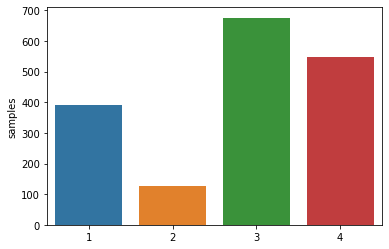

In [ ]:
jobflag_vals = submission.flag.value_counts()
sns.barplot(jobflag_vals.index, jobflag_vals)
plt.gca().set_ylabel('samples')

In [ ]:
submission.to_csv('damedesyo.csv', index=False)

from google.colab import files
files.download('damedesyo.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

non bi-tri feature: 0.4462  
bi-tri added feature: 0.427  
bi-tri balanced: 0.448  
my lgb: 0.378  


In [25]:
aug_submission.shape

(1743, 5)

In [26]:
aug_prob = pd.DataFrame()
aug_prob = np.stack([aug_submission['DataScientist'], aug_submission['MachineLearningEngineer'], aug_submission['SoftwareEngineer'], aug_submission['Consultant']], 1)
aug_y = hack(aug_prob) + 1

In [27]:
aug_y

array([4, 3, 2, ..., 1, 4, 3])

In [28]:
aug_submission['flag'] = aug_y
aug_submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant,flag
0,2931,0.310116,0.377305,0.370746,0.683276,4
1,2932,0.182285,0.312524,0.646621,0.436118,3
2,2933,0.283346,0.481744,0.558891,0.402133,2
3,2934,0.864356,0.399066,0.142520,0.258411,1
4,2935,0.226008,0.139362,0.546782,0.689232,4
...,...,...,...,...,...,...
1738,4669,0.871477,0.159681,0.140665,0.391781,1
1739,4670,0.192468,0.285787,0.557238,0.563758,4
1740,4671,0.538572,0.384747,0.373247,0.451523,1
1741,4672,0.277085,0.224150,0.465050,0.593346,4


Text(0.5, 1.0, '0.467_subimit_data')

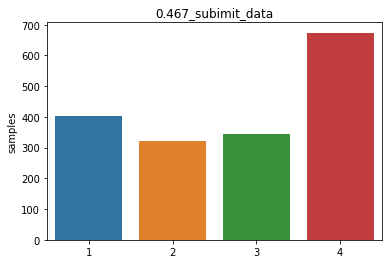

In [35]:
jobflag_vals = aug_submission.flag.value_counts()
sns.barplot(jobflag_vals.index, jobflag_vals)
plt.gca().set_ylabel('samples')
plt.gca().set_title('0.467_subimit_data')

In [31]:
aug_submission.to_csv('hidoi.csv', index=False)

from google.colab import files
files.download('hidoi.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>